<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/LogReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !python -m spacy download ru_core_news_sm

In [ ]:
!pip install pymorphy2

In [164]:
import sys
import sklearn
import nltk
import spacy
from spacy.lang.ru import Russian
from spacy.lang.ru.stop_words import STOP_WORDS as STOP_WORDS_RU
import pandas as pd
import string
from google.colab import files
import pymorphy2
from tqdm import notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import re
from tqdm import notebook
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer 
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
import spacy as sp
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from nltk.probability import FreqDist
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
print('Python version:', sys.version)
print('Sklearn version:', sklearn.__version__)

Python version: 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]
Sklearn version: 1.0.2


In [171]:
data = pd.read_csv('labeled.csv')
data.head(10)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
5,Для каких стан является эталоном современная с...,1.0
6,В шапке были ссылки на инфу по текущему фильму...,0.0
7,УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РА...,1.0
8,"Ебать тебя разносит, шизик.\n",1.0
9,"Обосрался, сиди обтекай\n",1.0


In [172]:
COL_TEXT='comment'
COL_LABEL='toxic'

In [173]:
data['comment'] = data['comment'].values.astype('U')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


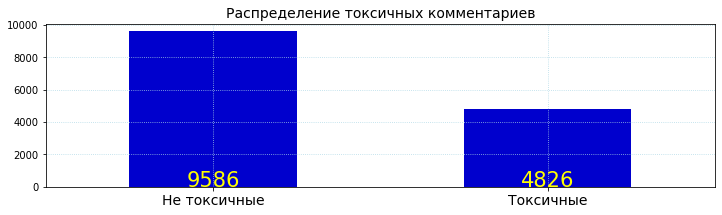

In [174]:
fig, ax = plt.subplots(figsize=(12, 3))

toxic = (data['toxic'].value_counts()).plot(kind='bar',  
                                   color='mediumblue').set_title(
    'Распределение токсичных комментариев', 
    fontdict={'fontsize': 14}
)
ax.set_xticklabels(['Не токсичные', 'Токсичные'], rotation=0, fontsize=14, )
plt.grid(color='lightblue', linestyle=':')
plt.text(0, 1, (data['toxic'].value_counts())[0], horizontalalignment='center', fontsize=21, color='yellow')
plt.text(1, 1, (data['toxic'].value_counts())[1], horizontalalignment='center', fontsize=21, color='yellow')
plt.show()

In [175]:
print('Количество дубликатов -', data.duplicated().sum())

Количество дубликатов - 0


In [176]:
morph = pymorphy2.MorphAnalyzer()
def lemmatize_word(word: str) -> str:
    try:
        p = morph.parse(word)[0]
        return p.normal_form 
    except:
        return word

In [177]:
def clear_text(text):
    text= text.lower()
    clear = re.sub(r'[^а-яА-Я]', ' ', text) # все кроме букв
    clear = re.sub(r"\s+[а-яА-Я]\s+", ' ', clear) # одиночные буквы
    clear = re.sub(r'\s+', ' ', clear) # лишние пробелы
     
    return ' '.join([lemmatize_word(word) for word in clear.split(' ')])

In [178]:
%%time
data['comment'] = data['comment'].apply(clear_text)

CPU times: user 1min 15s, sys: 5.36 ms, total: 1min 15s
Wall time: 1min 16s


In [179]:
data.head(10)
# data.tail()

,comment,toxic
0,верблюд то за что дебил бл,1.0
1,хохол это отдушина затюканый россиянин мол вон...,1.0
2,собака собачий смерть,1.0
3,страница обновить дебил это тоже не оскорблени...,1.0
4,ты не убедить страничный пдф тот что скрипаль ...,1.0
5,для какой стан являться эталон современный сис...,1.0
6,в шапка быть ссылка на инф по текущий фильм ма...,0.0
7,упад там нельзя строить технология нет разворо...,1.0
8,ебать ты разносить шизик,1.0
9,обосраться сидеть обтекать,1.0


In [180]:
FILE_NAME_CLEAR_DATA='toxic_comment_RU_cleaned.csv'
data=data.astype({'toxic': 'int64'})
data.to_csv(FILE_NAME_CLEAR_DATA, encoding='utf-8', index=False)
# files.download(FILE_NAME)

In [12]:
data1 = pd.read_csv(FILE_NAME_CLEAR_DATA)
data1.head()

,comment,toxic
0,верблюд то за что дебил бл,1.0
1,хохол это отдушина затюканый россиянин мол вон...,1.0
2,собака собачий смерть,1.0
3,страница обновить дебил это тоже не оскорблени...,1.0
4,ты не убедить страничный пдф тот что скрипаль ...,1.0


Разделение выборок, преобразование текстов

In [344]:
df = pd.read_csv(FILE_NAME_CLEAR_DATA)
X_train, X_test, y_train, y_test = train_test_split(df['comment'], df['toxic'], test_size=.2, random_state=7)

**LogisticRegression** подбор гиперпараметров

In [345]:
vectorize = TfidfVectorizer(
               min_df=3, max_df=0.8)

In [346]:
# рассчитываем TF-IDF слов
X_train = vectorize.fit_transform(X_train)
X_test = vectorize.transform(X_test)

In [347]:
lr_m = LogisticRegression()
lr_m.fit(X_train, y_train)

LogisticRegression()

In [349]:
pred = lr_m.predict(X_test)

Accuracy: 87.37 %
Recall: 70.03 %
Precision: 90.75 %
F1-score: 79.06 % 



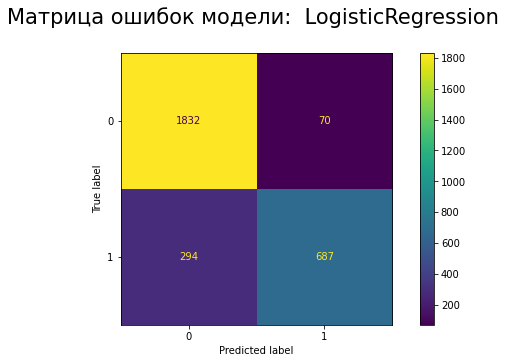

In [350]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def score_to_percent(score):
    return str(round(score * 100, 2)) + ' %'

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
_ = ax.set_title(f"Матрица ошибок модели:  {lr_m.__class__.__name__} \n", fontdict={'fontsize':21})
print("Accuracy:", score_to_percent(accuracy_score(y_test, pred)))
print("Recall:", score_to_percent(recall_score(y_test, pred)))
print("Precision:",score_to_percent(precision_score(y_test, pred)))
print("F1-score:", score_to_percent(f1_score(y_test, pred)), '\n')

**Представим топ нейтральных и токсичных слов в текстах датасета**

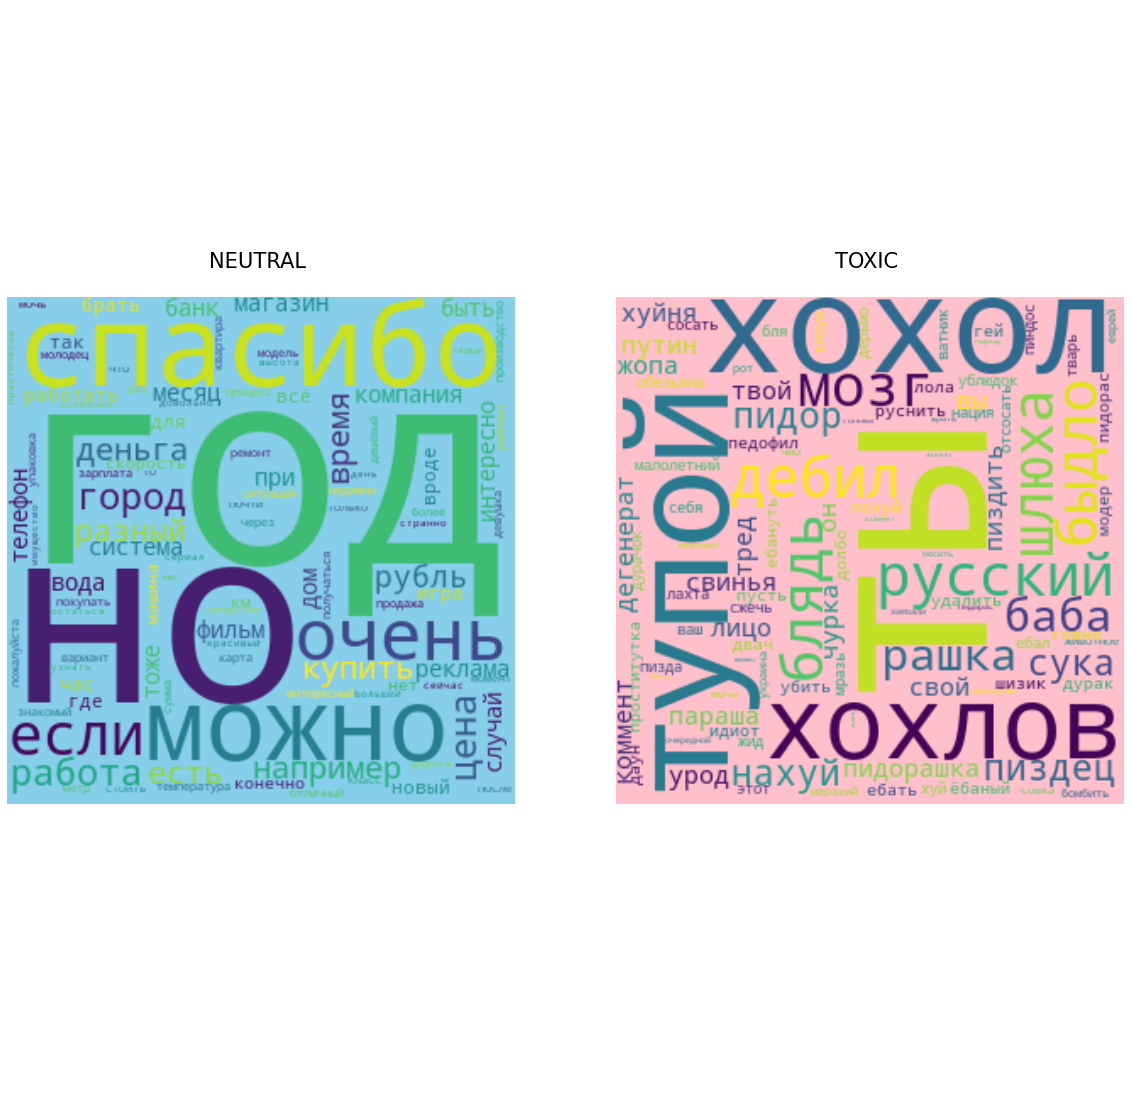

In [354]:
wordplot(negative, positive)

In [353]:
def wordplot(txt_toxic, txt_neutral):
    
    txt_toxic=' '.join(txt_toxic)
    txt_neutral=' '.join(txt_neutral)

    fig, axs = plt.subplots(figsize=(20, 20))
    plt.axis('off')
    ax = fig.add_subplot(1, 2, 1)

    WIDTH=300
    HEIGHT=300
    
    wordcloud = WordCloud(width=WIDTH, height=HEIGHT, background_color="skyblue").generate(txt_neutral)
    plt.axis('off')

    FONTSIZE=21
    INTERPOLATION='bilinear'

    plt.imshow(wordcloud, interpolation=INTERPOLATION)
    plt.title('NEUTRAL \n', fontsize=FONTSIZE)
    plt.margins(x=1, y=1)

    ax = fig.add_subplot(1, 2, 2)
    wordcloud = WordCloud(width=WIDTH, height=HEIGHT, background_color="pink").generate(txt_toxic)
    
    plt.imshow(wordcloud, interpolation=INTERPOLATION)
    plt.title('TOXIC \n', fontsize=FONTSIZE)
    plt.margins(x=1, y=0)
    plt.axis('off')
    plt.show()

In [352]:
feature_to_coef = { word: coef for word, coef in zip(vectorize.get_feature_names_out(), lr_m.coef_[0]) }

toxic, neutral   = [], []

for best_negative in sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:50]:
    toxic.append(best_negative[0])

for best_positive in sorted(feature_to_coef.items(), key=lambda x: x[1])[:50]:
    neutral.append(best_positive[0])